In [1]:
import rasterio
import numpy as np
import matplotlib as mpl
import subprocess
from matplotlib import pyplot
from rasterio.merge import merge
import geopandas as gpd
import os, math

In [2]:
geotiffPath = 'MERGED/20130301/'
NDWI2 = rasterio.open(geotiffPath + 'NDWI2.TIF')

In [3]:
from matplotlib import pyplot as plt
vn_reservoirs_path = 'vnreservoirs/VN_Reservoirs.shp'
df = gpd.read_file(vn_reservoirs_path)
plt.rcParams['figure.figsize'] = 5, 5
ho_tri_an = df[df.AREA_SKM == 277.4]

In [4]:
from rasterio.crs import CRS
from rasterio.warp import transform_geom
import rasterio.mask

from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from descartes import PolygonPatch

In [275]:
raw_file = NDWI2
trans = raw_file.transform

ho_tri_an_shape = ho_tri_an.geometry.values[0]
ho_tri_an_geom = mapping(ho_tri_an_shape)
ho_tri_an_shape = [transform_geom(df.crs, raw_file.crs,ho_tri_an_geom)]

/home/anhldt/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Find Rectangle that can bound!

In [54]:
inf = float("inf")
eps = 4000
x0, y0, x1, y1 = [inf, -inf, -inf, inf] #top-left, bottom-right
for x, y in ho_tri_an_shape[0]['coordinates'][0]:
    if x0 > x:
        x0 = x
    if x1 < x:
        x1 = x
    if y0 < y:
        y0 = y
    if y1 > y:
        y1 = y
new_coordinates = [{'type': 'Polygon', 'coordinates': [[(x0-eps, y0+eps),(x1+eps, y0+eps), 
                                                        (x1+eps, y1-eps), (x0-eps, y1-eps)]]}]
ndwi2, _ = rasterio.mask.mask(NDWI2, new_coordinates, crop=True)
ndwi2 = ndwi2.squeeze()

In [55]:
def insideMatrix(x, y, m, n):
    if x < 0 or x >= m or y < 0 or y >= n:
        return False
    return True

def check_expansion(val, type_of_map):
    if (type_of_map == 'NDVI'):
        if (val < 0):
            return True;
        return False;
    if (type_of_map == 'NDWI'):
        if (val > 0):
            return True;
        return False;
    if (type_of_map == 'NDWI2'):
        if (val > 0):
            return True;
        return False;  
    return null;

def count_pixel(obj, type_of_map, startingPoint):
    from queue import Queue
    dx = [0,1,0,-1]
    dy = [1,0,-1,0]

    visited = np.zeros((obj.shape[0], obj.shape[1])).astype('bool')
    final_obj= np.zeros((obj.shape[0], obj.shape[1])).astype(np.uint8)

    u0, v0 = startingPoint[0], startingPoint[1]

    q = Queue()
    q.put((u0, v0))
    visited[u0, v0] = True
    countPixel = 0

    while not q.empty():
        u, v = q.get()
        final_obj[u, v] = 1
        countPixel += 1
        for k in range(4):
            _u, _v = u + dx[k], v + dy[k]
            if not insideMatrix(_u, _v, obj.shape[0], obj.shape[1]): 
                continue
            if visited[_u, _v]:
                continue
            if check_expansion(obj[_u, _v], type_of_map):
                visited[_u, _v] = True
                q.put((_u, _v))
    return countPixel, final_obj

## Segmentation based on BFS

Area = 298.9638


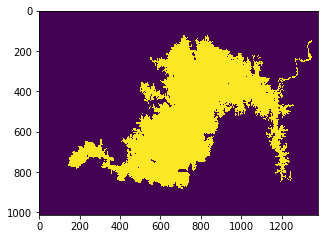

In [56]:
area, segment_array = count_pixel(ndwi2, 'NDWI2', [500, 600])
print("Area = {0}".format(area * 900 / 1000000))
plt.imshow(segment_array)

Normalize Segmented file

In [58]:
for j in range(segment_array.shape[1]):
    segment_array[0][j] = 0
    segment_array[1][j] = 0
    segment_array[2][j] = 0
    segment_array[3][j] = 0
    segment_array[4][j] = 0
    segment_array[segment_array.shape[0] - 1][j] = 0
    segment_array[segment_array.shape[0] - 2][j] = 0
    segment_array[segment_array.shape[0] - 3][j] = 0
    segment_array[segment_array.shape[0] - 4][j] = 0
    segment_array[segment_array.shape[0] - 5][j] = 0
for i in range(segment_array.shape[0]):
    segment_array[i][0] = 0
    segment_array[i][1] = 0
    segment_array[i][2] = 0
    segment_array[i][3] = 0
    segment_array[i][4] = 0
    segment_array[i][segment_array.shape[1] - 1] = 0
    segment_array[i][segment_array.shape[1] - 2] = 0
    segment_array[i][segment_array.shape[1] - 3] = 0
    segment_array[i][segment_array.shape[1] - 4] = 0
    segment_array[i][segment_array.shape[1] - 5] = 0
    

## Find Boundaries of Image

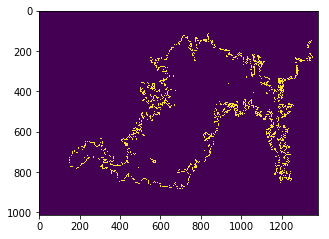

In [153]:
from skimage.segmentation import find_boundaries
boundaries_array = find_boundaries(segment_array, connectivity=8, mode='inner', background=100).astype(np.int16)
plt.imshow(boundaries_array)

Depends all boundaries found, choose the most similar to original.

In [190]:
shapes = []
__shape = None
dif = 123456789 #INFINITY

for _, __ in rasterio.features.shapes(boundaries_array,transform=trans):
    e = len(ho_tri_an_geom['coordinates']) - len(_['coordinates'])
    e = abs(e)
    if e < dif and len(ho_tri_an_geom['coordinates']) < len(_['coordinates']):
        dif = e
        __shape = _
    # print(len(_['coordinates']))

/home/anhldt/.local/lib/python3.5/site-packages/rasterio/features.py:102: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [232]:
original_shape = shape(ho_tri_an_shape[0])
processed_shape = shape(__shape)

## Try to convert to original coordinates and Masking

In [279]:
new_shape_in_original_coordinates = [transform_geom(raw_file.crs, df.crs, mapping(processed_shape))]

In [283]:
new_shape = shape(new_shape_in_original_coordinates[0])
new_geom = mapping(new_shape)
new_shape = [transform_geom(df.crs, raw_file.crs, new_geom)]

In [284]:
ho_tri_an_shape = ho_tri_an.geometry.values[0]
ho_tri_an_geom = mapping(ho_tri_an_shape)
ho_tri_an_shape = [transform_geom(df.crs, raw_file.crs,ho_tri_an_geom)]

In [298]:
ho_tri_an_shape

[{'coordinates': [[(722497.8341924414, 1229672.9702216492),
    (722487.1885036117, 1229710.354030234),
    (722460.7564186318, 1229683.250682137),
    (722497.8341924414, 1229672.9702216492),
    (722469.9160857479, 1229583.7588073076),
    (722409.0485228671, 1229518.7225235542),
    (722361.6959793954, 1229564.168486633),
    (722311.4717959599, 1229717.2530459354),
    (722269.5846145698, 1229717.8364193595),
    (722229.2371761752, 1229632.1117658075),
    (722060.0557459394, 1229807.9724075403),
    (721966.6770204729, 1229718.3136047707),
    (721908.7643192926, 1229470.3670928003),
    (721789.6224989268, 1229407.1847608436),
    (721642.0057265363, 1229453.0569613795),
    (721572.9635706197, 1229586.5048483035),
    (721602.2776388272, 1229651.773939776),
    (721662.1647784845, 1229771.5160773764),
    (721605.2481591287, 1229893.8216943168),
    (721359.6195240502, 1229897.2167288335),
    (721297.7173396792, 1229803.3630114298),
    (721220.3217711329, 1229682.0617494092),

In [299]:
new_shape

[{'coordinates': [[(712694.9999993399, 1380464.999999948),
    (712694.9999993392, 1380434.999999948),
    (712664.9999993402, 1380434.999999948),
    (712664.9999993413, 1380404.999999948),
    (712634.9999993418, 1380404.999999948),
    (712634.9999993407, 1380374.9999999483),
    (712604.999999342, 1380374.9999999483),
    (712604.999999343, 1380314.999999948),
    (712574.9999993426, 1380314.999999948),
    (712574.9999993433, 1380104.9999999483),
    (712544.999999343, 1380104.9999999485),
    (712544.9999993433, 1380074.9999999483),
    (712514.9999993445, 1380074.9999999483),
    (712484.999999343, 1380074.999999948),
    (712484.9999993441, 1380014.9999999483),
    (712454.9999993453, 1380014.9999999485),
    (712454.9999993437, 1379984.9999999483),
    (712424.9999993448, 1379984.9999999483),
    (712364.9999993468, 1379984.9999999488),
    (712364.9999993443, 1379894.9999999483),
    (712334.9999993464, 1379894.9999999485),
    (712334.9999993457, 1379864.9999999488),
    (71

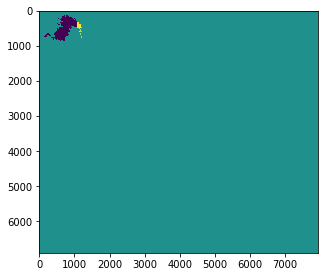

In [297]:
ndwi2_origin, _ = rasterio.mask.mask(NDWI2, ho_tri_an_shape)
ndwi2_processed, __ = rasterio.mask.mask(NDWI2, new_shape)
ndwi2_origin = ndwi2_origin.squeeze()
ndwi2_processed = ndwi2_processed.squeeze()
plt.imshow(ndwi2_processed)

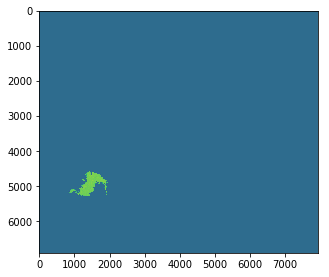

In [292]:
plt.imshow(ndwi2_origin)